In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
#gpuの確認
print(torch.cuda.is_available())

True


In [2]:
#学習済みの分散表現をロードする
from torchtext.vocab import Vectors

english_fasttext_vectors = Vectors(name='drive/My Drive/wiki-news-300d-1M.vec')

print(english_fasttext_vectors.dim)
print(len(english_fasttext_vectors.itos))

100%|█████████▉| 999437/999994 [01:35<00:00, 10524.49it/s]

300
999994


In [28]:
import string
import re

# 以下の記号はスペースに置き換えます（カンマ、ピリオドを除く）。
# punctuationとは日本語で句点という意味です
print("区切り文字：", string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# 前処理


def preprocessing_text(text):
    # 改行コードを消去
    text = re.sub('<br />', '', text)

    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ","):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）


def tokenizer_punctuation(text):
    return text.strip().split()


# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret


# 動作を確認します
print(tokenizer_with_preprocessing('I like cats+'))

区切り文字： !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['I', 'like', 'cats']


In [29]:
import torchtext
from torchtext.data.utils import get_tokenizer

#テキストに処理を行うFieldを定義
#fix_lengthはtokenの数
TEXT = torchtext.data.Field(sequential=True, use_vocab=True, tokenize=tokenizer_with_preprocessing,
                            lower=True, include_lengths=True, batch_first=True, fix_length=37)

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

#pandasでcsvを保存するときに、labelをintでキャストしておかないとエラーでるから注意
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(
    path='drive/My Drive/dataset/CBET/ekman', train='train.csv', validation='val.csv', 
    test='test.csv', format='csv', fields=[('Text', TEXT), ('Label', LABEL)])

In [30]:
#ボキャブラリを作成する
TEXT.build_vocab(train_ds, vectors=english_fasttext_vectors)

print(len(TEXT.vocab.stoi))

batch_size = 64
d_model = 300
hidden_size = 512
output_dim = 5
dropout_rate = 0.5

51709


In [31]:
#データローダを作成
train_dl = torchtext.data.Iterator(train_ds, batch_size=batch_size, train=True)
val_dl = torchtext.data.Iterator(val_ds, batch_size=batch_size, train=False, sort=False)
test_dl = torchtext.data.Iterator(test_ds, batch_size=batch_size, train=False, sort=False)

#テスト
batch = next(iter(val_dl))
print(len(batch.Text[0][0]))
print(batch.Label)

37
tensor([4, 0, 2, 0, 2, 4, 4, 3, 1, 4, 2, 2, 1, 2, 2, 2, 1, 2, 3, 3, 0, 3, 4, 1,
        1, 3, 0, 2, 4, 1, 2, 2, 2, 3, 1, 2, 4, 3, 3, 4, 0, 0, 1, 3, 0, 3, 4, 0,
        0, 1, 2, 2, 1, 1, 4, 3, 2, 3, 3, 3, 2, 4, 4, 2])


In [32]:
class Embedder(nn.Module):
  def __init__(self, text_embedding_vectors, dropout_rate):
    super(Embedder, self).__init__()
    #tokenの数と、分散表現の次元数
    self.embeddings = nn.Embedding.from_pretrained(
        embeddings=text_embedding_vectors, freeze=True)
    self.dropout = nn.Dropout(dropout_rate)
  
  def forward(self, x):
    x = self.embeddings(x)
    x = self.dropout(x)
    return x


class LSTM_Layer(nn.Module):
  def __init__(self, d_model, hidden_size, dropout_rate):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(d_model, hidden_size, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(dropout_rate)

  #入力と(h, c)のタプル
  def forward(self, x):
    #[batch_size, ntoken, hidden_size*2], ([2, batch_size, hidden_size], [2, batch_size, hidden_size])
    output, (hn, cn) = self.lstm(x)
    output = torch.cat([hn[i, : ,:] for i in range(hn.shape[0])], dim=1) #[batch_size, hidden_size*2]
    output = self.dropout(output)
    return output, (hn, cn)

  
class ClassificationHead(nn.Module):
  def __init__(self, hidden_size, output_dim):
    super().__init__()
    self.linear = nn.Linear(hidden_size*2, output_dim)
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, x):
    output = self.linear(x)
    return output

class LSTM_Classification(nn.Module):
  def __init__(self, text_embedding_vectors, d_model, hidden_size, output_dim, dropout_rate):
    super().__init__()
    self.hidden_size = hidden_size
    self.net1 = Embedder(text_embedding_vectors, dropout_rate)
    self.net2 = LSTM_Layer(d_model, hidden_size, dropout_rate)
    self.net3 = ClassificationHead(hidden_size, output_dim)

  def forward(self, x):
    x1 = self.net1(x) # [batch_size, ntoken, d_model]
    x2, (ht, ct) = self.net2(x1) # [batch_size, ntoken, hidden_size], ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
    #隠れ状態の最後を使う
    out = self.net3(x2) 
    return out

In [33]:
#テスト


batch = next(iter(train_dl))
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

# モデル構築
net = LSTM_Classification(TEXT.vocab.vectors, d_model, hidden_size, output_dim, dropout_rate) 
#hidden = net.init_hidden(device)

# 入出力
x = batch.Text[0]
x1 = net(x)

print("入力のテンソルサイズ：", x.shape)
print("出力のテンソルサイズ：", x1.shape)

入力のテンソルサイズ： torch.Size([64, 37])
出力のテンソルサイズ： torch.Size([64, 5])


In [34]:
dataloaders_dict = {'train': train_dl, 'val': val_dl}
criterion = nn.CrossEntropyLoss() 
net = LSTM_Classification(TEXT.vocab.vectors, d_model, hidden_size, output_dim, dropout_rate) 
net.train()

learning_rate = 10e-4
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [35]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net.to(device)

  torch.backends.cudnn.benchmark = True

  #各epoch
  for epoch in range(num_epochs):
    #訓練と評価
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()
      
      epoch_loss = 0.0 #各epochの損失の和
      epoch_corrects = 0 #各epochの正解数

      for batch in (dataloaders_dict[phase]):
        inputs = batch.Text[0].to(device)
        labels = batch.Label.to(device)

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase=='train'):
          #hidden = net.init_hidden(device) #LSTM隠れ状態の初期化
          outputs = net(inputs) #[batch_size, output_dim]

          loss = criterion(outputs, labels) #softmaxは中に入ってる
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward() #勾配を計算
            optimizer.step() #パラメータを更新

          epoch_loss += loss.item()*inputs.size(0) #バッチ数をかけてあとでデータ量で割る
          epoch_corrects += torch.sum(preds == labels.data)
      
      #各epochのloss、正解数をだす
      epoch_loss = epoch_loss/len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)
      print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,
                                                                     num_epochs, phase, epoch_loss, epoch_acc))
  return net

In [36]:
num_epochs = 20
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)

Epoch 1/20 | train |  Loss: 1.2771 Acc: 0.4661
Epoch 1/20 |  val  |  Loss: 1.0619 Acc: 0.5859
Epoch 2/20 | train |  Loss: 1.0939 Acc: 0.5707
Epoch 2/20 |  val  |  Loss: 1.0110 Acc: 0.6117
Epoch 3/20 | train |  Loss: 1.0344 Acc: 0.5960
Epoch 3/20 |  val  |  Loss: 0.9741 Acc: 0.6219
Epoch 4/20 | train |  Loss: 1.0048 Acc: 0.6072
Epoch 4/20 |  val  |  Loss: 0.9547 Acc: 0.6346
Epoch 5/20 | train |  Loss: 0.9766 Acc: 0.6196
Epoch 5/20 |  val  |  Loss: 0.9400 Acc: 0.6416
Epoch 6/20 | train |  Loss: 0.9517 Acc: 0.6301
Epoch 6/20 |  val  |  Loss: 0.9196 Acc: 0.6372
Epoch 7/20 | train |  Loss: 0.9283 Acc: 0.6384
Epoch 7/20 |  val  |  Loss: 0.9135 Acc: 0.6506
Epoch 8/20 | train |  Loss: 0.9035 Acc: 0.6496
Epoch 8/20 |  val  |  Loss: 0.8967 Acc: 0.6494
Epoch 9/20 | train |  Loss: 0.8847 Acc: 0.6565
Epoch 9/20 |  val  |  Loss: 0.9017 Acc: 0.6562
Epoch 10/20 | train |  Loss: 0.8618 Acc: 0.6649
Epoch 10/20 |  val  |  Loss: 0.8970 Acc: 0.6526
Epoch 11/20 | train |  Loss: 0.8332 Acc: 0.6775
Epoch 11/2

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()
net_trained.to(device)

y_true = np.array([])
y_pred = np.array([])

epoch_corrects = 0

for batch in (test_dl):
  inputs = batch.Text[0].to(device)
  labels = batch.Label.to(device)

  with torch.set_grad_enabled(False):
    outputs = net_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    y_true = np.concatenate([y_true, labels.to("cpu", torch.double).numpy()])
    y_pred = np.concatenate([y_pred, preds.to("cpu", torch.double).numpy()])

    epoch_corrects += torch.sum(preds == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dl.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dl.dataset),epoch_acc))

テストデータ4569個での正解率：0.6715


In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.49      0.55       870
         1.0       0.79      0.76      0.77       900
         2.0       0.82      0.77      0.79      1063
         3.0       0.51      0.64      0.57       880
         4.0       0.64      0.68      0.66       856

    accuracy                           0.67      4569
   macro avg       0.67      0.67      0.67      4569
weighted avg       0.68      0.67      0.67      4569



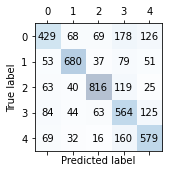

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()